# Block Resampling & Z Scores

### To Do List

1. Generate extreme indices for seasons (warm season, cool season, wet season, dry season)
2. Generate new sequence based on multiple warm years, cool years, wet years, dry years etc. 

### User-Defined Variables

In [41]:
startyear = 2008 #first year of your weather data
endyear = 2014 #second year of your weather data
outputyears = 50 #number of years in your generated sequence

### Load Necessary Packages

In [42]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pyeto
from pyeto import hargreaves
%matplotlib inline

### Read in & display climate data

In [43]:
df = pd.read_csv("E:\PhD\Data\MetData\Raw\dly375 (Oak Park)\dly375.csv",skiprows=16, na_values=[' '])
df.head()

,date,imax,maxtp,imin,mintp,irain,rain,cbl,wdsp,ihm,hm,iddhm,ddhm,ihg,hg,soil
0,01-jan-2007,0,6.1,0,3.6,0,4.8,1005.9,10.7,0,23,0,250,0,33,4.071
1,02-jan-2007,0,9.4,0,4.8,0,0.4,1017.2,11.3,0,21,0,240,0,33,4.304
2,03-jan-2007,0,12.1,0,8.1,0,2.9,1005.7,14.6,0,25,0,250,0,38,7.723
3,04-jan-2007,0,9.7,0,7.3,0,0.0,1004.2,12.8,0,23,0,260,0,35,6.758
4,05-jan-2007,0,10.2,0,4.7,0,0.8,1005.5,9.4,0,14,0,260,0,19,6.760


Convert 'date' column to datetime object

In [44]:
df['date'] = pd.to_datetime(df['date'], format= '%d-%b-%Y') # https://docs.python.org/2/library/datetime.html see end of this page for %d %m %Y

### Remove incomplete years
Count the number of days in each year

In [45]:
count = df.set_index([df['date'].dt.year, df['date'].dt.day]).count(level=0) #indexes by year, counts the days

Drop years which have less than 365 days

In [46]:
count = count.drop(count[count.date < 365].index)

Create a 'years' variable which has all years with 365 days or more in it

In [47]:
years = count[count['date'] >= 365].index 

Reformat the dataframe based on full years

In [48]:
df = df[df['date'].dt.year.isin(years)]
df.tail()

,date,imax,maxtp,imin,mintp,irain,rain,cbl,wdsp,ihm,hm,iddhm,ddhm,ihg,hg,soil
2917,2014-12-27,0,5.2,0,0.3,0,0,1011.2,7.3,0,12,0,290,0,20,3.151
2918,2014-12-28,0,3.0,0,-3.7,0,0,1024.3,3.7,0,9,0,330,0,15,1.357
2919,2014-12-29,0,5.1,0,-5.3,0,0,1033.0,3.3,0,8,0,150,0,10,0.668
2920,2014-12-30,0,8.8,0,-0.4,0,0,1026.3,7.3,0,15,0,150,0,22,0.982
2921,2014-12-31,0,11.0,0,8.3,0,1,1017.0,12.4,0,17,0,180,0,26,5.942


Calculate the number of years in the dataframe (to be used later when getting monthly precipitation baseline)

In [49]:
no_of_years = df['date'].dt.year.nunique()
no_of_years

8

Remove the final 31 rows to get rid of December, as it will only have a 1 month value

In [50]:
df = df.drop(df.index[-31:])
df.tail()

,date,imax,maxtp,imin,mintp,irain,rain,cbl,wdsp,ihm,hm,iddhm,ddhm,ihg,hg,soil
2886,2014-11-26,0,4.5,0,-2.1,0,0,1005.0,1.3,0,5,0,110,0,6,3.627
2887,2014-11-27,0,9.7,0,-0.9,0,0,994.4,4.4,0,12,0,120,0,20,3.758
2888,2014-11-28,0,12.7,0,4.9,0,0,994.8,5.4,0,11,0,80,0,17,6.788
2889,2014-11-29,0,9.4,0,5.9,0,0,1003.0,2.5,0,8,0,180,0,10,7.190
2890,2014-11-30,0,9.3,0,2.9,0,0,1008.8,3.1,0,7,0,320,0,11,6.590


### Create mean temp field

In [51]:
df['meantp'] = (df['maxtp'] + df['mintp'])/2
df.meantp = df.meantp.round(1) #keep Tmean to one decimal place as that's what's in the original dat
#NOTE:Numpy rounds to the nearest even value. Thus 1.5 and 2.5 round to 2.0, -0.5 and 0.5 round to 0.0, etc.

### Calculate PET using [Hargreaves method](https://github.com/woodcrafty/PyETo/blob/master/docs/hargreaves.rst) (from [PyETo package](https://github.com/woodcrafty/PyETo))

The hargreaves method is recommended by the FAO (Allen et al, 1998) where insufficient meterological data are available from Penman-Monteith)

It uses temperature and solar radiation which is estimated from the latitude and the time of year.

The Hargreaves equation has a tendency to under-estimate ETo under high wind conditions(u2 > 3m/s) and to over-estimate under conditions of high relative humidity.

**First specify latitude for your site, and create a 'day of year' column from the date:**

In [52]:
lat = pyeto.deg2rad(52.861) #latitude for Oak Park Carlow

df['lat']= lat #add column to the dataframe

df['dayofyear'] = pd.DatetimeIndex(df['date']).dayofyear #create 'day of year' column to calculate sunshine variables

Estimate solar declination (sol_dec), sunset hour angle (sha), inverse relative distance from Earth to the sun (ird), and ET radiation (et_rad)

In [53]:
sol_dec = df['dayofyear'].apply(pyeto.sol_dec)   # Solar declination
df['sol_dec'] = sol_dec #add column

sha = df.apply(lambda x: pyeto.sunset_hour_angle(x['lat'],x['sol_dec']), axis=1)
df['sha'] = sha #add column

ird = df['dayofyear'].apply(pyeto.inv_rel_dist_earth_sun)
df['ird'] = ird

et_rad = df.apply(lambda x: pyeto.et_rad(x['lat'],x['sol_dec'],x['sha'],x['ird']), axis =1)   # Extraterrestrial radiation
df['et_rad'] = et_rad

df.head()

,date,imax,maxtp,imin,mintp,irain,rain,cbl,wdsp,ihm,...,ihg,hg,soil,meantp,lat,dayofyear,sol_dec,sha,ird,et_rad
0,2007-01-01,0,6.1,0,3.6,0,4.8,1005.9,10.7,0,...,0,33,4.071,4.8,0.922598,1,-0.401008,0.976637,1.032995,6.083577
1,2007-01-02,0,9.4,0,4.8,0,0.4,1017.2,11.3,0,...,0,33,4.304,7.1,0.922598,2,-0.399564,0.979348,1.032980,6.134697
2,2007-01-03,0,12.1,0,8.1,0,2.9,1005.7,14.6,0,...,0,38,7.723,10.1,0.922598,3,-0.398001,0.982272,1.032956,6.190089
3,2007-01-04,0,9.7,0,7.3,0,0.0,1004.2,12.8,0,...,0,35,6.758,8.5,0.922598,4,-0.396320,0.985406,1.032922,6.249764
4,2007-01-05,0,10.2,0,4.7,0,0.8,1005.5,9.4,0,...,0,19,6.760,7.4,0.922598,5,-0.394522,0.988748,1.032878,6.313735


Apply the 'hargreaves' function

In [54]:
PEcalc = df.apply(lambda x: hargreaves(x['mintp'], x['maxtp'], x['meantp'], x['et_rad']),axis=1)
df['hargreaves'] = PEcalc #create a column
df.head()

,date,imax,maxtp,imin,mintp,irain,rain,cbl,wdsp,ihm,...,hg,soil,meantp,lat,dayofyear,sol_dec,sha,ird,et_rad,hargreaves
0,2007-01-01,0,6.1,0,3.6,0,4.8,1005.9,10.7,0,...,33,4.071,4.8,0.922598,1,-0.401008,0.976637,1.032995,6.083577,0.203998
1,2007-01-02,0,9.4,0,4.8,0,0.4,1017.2,11.3,0,...,33,4.304,7.1,0.922598,2,-0.399564,0.979348,1.032980,6.134697,0.307439
2,2007-01-03,0,12.1,0,8.1,0,2.9,1005.7,14.6,0,...,38,7.723,10.1,0.922598,3,-0.398001,0.982272,1.032956,6.190089,0.324130
3,2007-01-04,0,9.7,0,7.3,0,0.0,1004.2,12.8,0,...,35,6.758,8.5,0.922598,4,-0.396320,0.985406,1.032922,6.249764,0.238953
4,2007-01-05,0,10.2,0,4.7,0,0.8,1005.5,9.4,0,...,19,6.760,7.4,0.922598,5,-0.394522,0.988748,1.032878,6.313735,0.350152


Compare hargreaves calculation to Met Eireann PE (Penman-Monteith method)

In [55]:
metPE = pd.read_excel("E:\PhD\Data\MetData\PE\OakPark 08-16.xlsx")
metPE['date'] = pd.to_datetime(metPE['date'], format= '%d-%b-%Y') #datetime object
metPE = metPE[metPE['date'].dt.year.isin(years)] #match the years of the observed data (met eireann PE starts at 2008)
metPE = metPE[['date','PE (mm)']]
metPE.head()

,date,PE (mm)
0,2008-01-01,0.546
1,2008-01-02,0.825
2,2008-01-03,0.416
3,2008-01-04,0.390
4,2008-01-05,0.253


Drop 2007 from hargreaves calculation

In [56]:
df2 = df.ix[365:]
df2 = df2[['date','hargreaves']]
df2.head()

,date,hargreaves
365,2008-01-01,0.313550
366,2008-01-02,0.276951
367,2008-01-03,0.265258
368,2008-01-04,0.391506
369,2008-01-05,0.284838


Merge the two dataframes

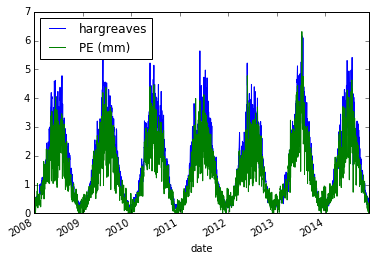

In [57]:
compare = df2.merge(metPE, on = 'date')
compare.head()
compare.plot(x='date')

Filter out unwanted columns

In [58]:
df = df[['date','meantp','hargreaves','rain']]
df.head()

,date,meantp,hargreaves,rain
0,2007-01-01,4.8,0.203998,4.8
1,2007-01-02,7.1,0.307439,0.4
2,2007-01-03,10.1,0.324130,2.9
3,2007-01-04,8.5,0.238953,0.0
4,2007-01-05,7.4,0.350152,0.8


Convert 'date' column to datetime object so Pandas can use it 

Split data into seasons based on months

Spring = 1, Summer = 2, Autumn = 3, Winter = 4

In [59]:
#create a season function to split data into seasons
def get_season(row):
    if row['date'].month >= 3 and row['date'].month <= 5:
        return '1'
    elif row['date'].month >= 6 and row['date'].month <= 8:
        return '2'
    elif row['date'].month >= 9 and row['date'].month <= 11:
        return '3'
    else:
        return '4'

Apply the season function to the data

In [60]:
df['Season'] = df.apply(get_season, axis=1)

Create 'Year' column from the 'date' column

In [61]:
df['Year'] = df['date'].dt.year

Make December of previous year part of winter for current year

In [62]:
#Redefine the year to attach December of previous year to winter of following year 
#Everywhere the month is '12', the year column gets increased by 1. 
df.loc[df['date'].dt.month == 12, 'Year'] += 1

Create a new dataframe indexed by Year and Season

In [63]:
#how to multiindex from here: http://stackoverflow.com/questions/33435971/selecting-time-series-data-in-a-specific-sequence-using-pandas/33437422#33437422
df2 = df.set_index(['Year', 'Season'], inplace=False)
df2.head()

date  meantp  hargreaves  rain
Year Season                                     
2007 4      2007-01-01     4.8    0.203998   4.8
     4      2007-01-02     7.1    0.307439   0.4
     4      2007-01-03    10.1    0.324130   2.9
     4      2007-01-04     8.5    0.238953   0.0
     4      2007-01-05     7.4    0.350152   0.8

# Temperature Extremes

Calculate mean values for each season

In [64]:
seasmean = df['meantp'].groupby(df['Season']).mean()
sprmean = seasmean['1']
summean = seasmean['2']
autmean = seasmean['3']
winmean = seasmean['4']

print seasmean

Season
1     8.905978
2    14.931565
3    10.456868
4     4.897829
Name: meantp, dtype: float64


Calculating differences between season and season means

In [65]:
seasdif = df2['meantp'].groupby(level=['Year','Season']).mean() - seasmean
seasdif

Year  Season
2007  1         0.823370
      2        -0.201130
      3         0.518956
      4         1.378442
2008  1        -0.044022
      2        -0.164173
      3        -0.922802
      4         1.196676
2009  1         0.113587
      2         0.040175
      3         0.176099
      4        -0.551163
2010  1        -0.502717
      2         0.355392
      3        -0.790934
      4        -2.493385
2011  1         0.669022
      2        -1.243653
      3         1.362912
      4        -1.857829
2012  1        -0.114674
      2        -0.326130
      3        -1.273352
      4         1.532940
2013  1        -1.678804
      2         1.151044
      3         0.406868
      4         0.212171
2014  1         0.734239
      2         0.374957
      3         0.522253
      4         1.026615
Name: meantp, dtype: float64

Visualise these seasonal differences

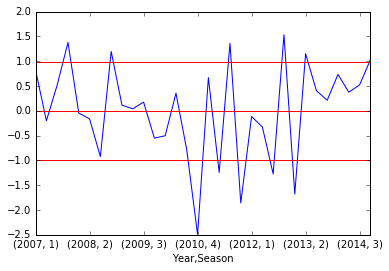

In [66]:
#visualise the seasonal differences (calculate greater than 2 standard deviations?)
seasdif.plot()
plt.axhline(0,color='red')
plt.axhline(seasdif.std() * 1, color ='red')
plt.axhline(-(seasdif.std()) * 1, color ='red')

# Rainfall Extremes

Calculate sum values for each season

In [67]:
rainsum = df['rain'].groupby(df['Season']).sum() / no_of_years #seasonal sums divided by number of years to get baseline rainfall
print rainsum

Season
1    151.1500
2    255.8750
3    244.8375
4    223.1625
Name: rain, dtype: float64


In [68]:
raindif = df2['rain'].groupby(level=['Year','Season']).sum() - rainsum #work out the anomalies
raindif

Year  Season
2007  1         -24.3500
      2          78.5250
      3        -155.8375
      4         -75.7625
2008  1           1.6500
      2         110.0250
      3         -28.9375
      4          15.0375
2009  1          52.8500
      2          62.8250
      3         140.3625
      4         -32.7625
2010  1          29.9500
      2         -99.0750
      3          20.4625
      4         -29.9625
2011  1         -64.9500
      2        -111.2750
      3          32.1625
      4           1.5375
2012  1         -26.6500
      2         110.6250
      3         -62.6375
      4         -72.3625
2013  1         -13.5500
      2        -104.3750
      3         -22.7375
      4         -43.0625
2014  1          45.0500
      2         -47.2750
      3          77.1625
      4         237.3375
Name: rain, dtype: float64

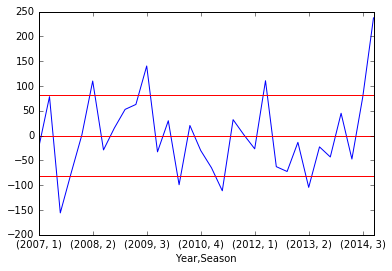

In [69]:
#visualise the seasonal differences (calculate greater than 2 standard deviations?)
raindif.plot()
plt.axhline(0,color='red')
plt.axhline(raindif.std() * 1, color ='red')
plt.axhline(-(raindif.std()) * 1, color ='red')

#NOTE: December 2015 is only one month, and should not be included (remove final 31 rows from the data?)

# Extracting extreme seasons

Create a copy of the dataframe and two blank lists for hot and cold extremes

In [70]:
seasdif2 = pd.DataFrame(seasdif)
warm = []
cold = []

Create a function which identifies warm and cold extremes based on the data

In [71]:
def extremetemp(x):
    for season in x:
        if season > x.std() * 1:
            warm.append(1)
        else:
            warm.append(0)

    for season in x:
        if season < (-(x.std()*1)):
            cold.append(1)
        else:
            cold.append(0)

Apply the function to the dataset

In [72]:
extremetemp(seasdif)

Create new columns in duplicate dataset to identify which season has an extreme value

In [73]:
seasdif2['cold']=cold
seasdif2['warm']=warm
seasdif2

meantp  cold  warm
Year Season                      
2007 1       0.823370     0     0
     2      -0.201130     0     0
     3       0.518956     0     0
     4       1.378442     0     1
2008 1      -0.044022     0     0
     2      -0.164173     0     0
     3      -0.922802     0     0
     4       1.196676     0     1
2009 1       0.113587     0     0
     2       0.040175     0     0
     3       0.176099     0     0
     4      -0.551163     0     0
2010 1      -0.502717     0     0
     2       0.355392     0     0
     3      -0.790934     0     0
     4      -2.493385     1     0
2011 1       0.669022     0     0
     2      -1.243653     1     0
     3       1.362912     0     1
     4      -1.857829     1     0
2012 1      -0.114674     0     0
     2      -0.326130     0     0
     3      -1.273352     1     0
     4       1.532940     0     1
2013 1      -1.678804     1     0
     2       1.151044     0     1
     3       0.406868     0     0
     4       0.212171     0     0
2014 1       0.734239     0     0
     2       0.374957     0     0
     3       0.522253     0     0
     4       1.026615     0     1

### Do the same for Rainfall

In [74]:
raindif2 = pd.DataFrame(raindif)
wet = []
dry = []

Create a function which identifies wet and dry extremes based on the data

In [75]:
def extremerain(x):
    for season in x:
        if season > x.std() * 1:
            wet.append(1)
        else:
            wet.append(0)

    for season in x:
        if season < (-(x.std()*1)):
            dry.append(1)
        else:
            dry.append(0)

Apply the function to the dataset

In [76]:
extremerain(raindif)

In [77]:
seasdif2['wet']=wet
seasdif2['dry']=dry
seasdif2

meantp  cold  warm  wet  dry
Year Season                                
2007 1       0.823370     0     0    0    0
     2      -0.201130     0     0    0    0
     3       0.518956     0     0    0    1
     4       1.378442     0     1    0    0
2008 1      -0.044022     0     0    0    0
     2      -0.164173     0     0    1    0
     3      -0.922802     0     0    0    0
     4       1.196676     0     1    0    0
2009 1       0.113587     0     0    0    0
     2       0.040175     0     0    0    0
     3       0.176099     0     0    1    0
     4      -0.551163     0     0    0    0
2010 1      -0.502717     0     0    0    0
     2       0.355392     0     0    0    1
     3      -0.790934     0     0    0    0
     4      -2.493385     1     0    0    0
2011 1       0.669022     0     0    0    0
     2      -1.243653     1     0    0    1
     3       1.362912     0     1    0    0
     4      -1.857829     1     0    0    0
2012 1      -0.114674     0     0    0    0
     2      -0.326130     0     0    1    0
     3      -1.273352     1     0    0    0
     4       1.532940     0     1    0    0
2013 1      -1.678804     1     0    0    0
     2       1.151044     0     1    0    1
     3       0.406868     0     0    0    0
     4       0.212171     0     0    0    0
2014 1       0.734239     0     0    0    0
     2       0.374957     0     0    0    0
     3       0.522253     0     0    0    0
     4       1.026615     0     1    1    0

### Select out combinations of data (warm/wet, warm/dry, cold/wet, cold/dry)

In [80]:
#identify columns with cold extremes (could do the same for warm but there are none)
seasdif2.loc[(seasdif2.cold==1) | (seasdif2.dry==1) | (seasdif2.warm==1) | (seasdif2.wet ==1)]

meantp  cold  warm  wet  dry
Year Season                                
2007 3       0.518956     0     0    0    1
     4       1.378442     0     1    0    0
2008 2      -0.164173     0     0    1    0
     4       1.196676     0     1    0    0
2009 3       0.176099     0     0    1    0
2010 2       0.355392     0     0    0    1
     4      -2.493385     1     0    0    0
2011 2      -1.243653     1     0    0    1
     3       1.362912     0     1    0    0
     4      -1.857829     1     0    0    0
2012 2      -0.326130     0     0    1    0
     3      -1.273352     1     0    0    0
     4       1.532940     0     1    0    0
2013 1      -1.678804     1     0    0    0
     2       1.151044     0     1    0    1
2014 4       1.026615     0     1    1    0

In [79]:
#blank dataframe
future = pd.DataFrame()

Loop through for x amount of years

In [ ]:
for i in range(outputyears):
    for season in ['1', '2', '3', '4']:
        future = future.append(df2.loc[np.random.choice(range(startyear, endyear))]
                                  .loc[season])

In [ ]:
future.head()

### Change the output directory and save the file

In [ ]:
#check spacing replace with underscore
os.chdir('E:\PhD\Data\Block Resampling')
#save the file
empty.to_csv('empty.csv', sep = ',')

# The following calculates z-scores, and doesn't make much sense...

In [ ]:
#zscore calculation 
df.dtypes #check column datatypes
df.head() #view header
cols = list(df.columns) #convert to list
cols.remove('date')
cols.remove('Season')
cols.remove('Year') #remove unnecessary columns
df[cols]

for col in cols:
    col_zscore = col + '_zscore'
    df[col_zscore] = (df[col] - df[col].mean())/df[col].std(ddof=0)
    
#minus the season mean and divide by the stddev of the seasmean

In [ ]:
#plotting z scores
df.plot(x='date',y='Tmean_zscore')    
plt.axhline(0, color='red')  
plt.axhline(0, color='red')
plt.axhline(1.96, color='red')
plt.axhline(-1.96, color='red')
plt.title('Mean Temperature Z-Score')
plt.xlabel('Year')
plt.ylabel('Z-Score')
plt.savefig('temp z score.png', dpi = 500)

### Calculate 'extremes' based on z-scores greater than 2 or less than -2

In [ ]:
extremes = df[(df['Tmean_zscore'] >=2) | (df['Tmean_zscore'] <= -2)]
extremes

In [ ]:
#figure out how to select 'normal' seasons and follow with 'extreme' seasons. 